In [69]:
def subsample_labels(df, labels):
    return df.loc[df['label'].isin(labels)]

In [119]:
def remove_au_features(df, au_list):
    for au in au_list:
        df.drop([f'AU{au}_std', f'AU{au}_mean', f'AU{au}_e0_length', f'AU{au}_e1_length', f'AU{au}_e2_length',
                f'AU{au}_e0_amount', f'AU{au}_e1_amount', f'AU{au}_e2_amount',
                f'AU{au}_e0_intensity', f'AU{au}_e1_intensity', f'AU{au}_e2_intensity'], axis=1, inplace=True)


In [70]:
def over_sample(df, label_='happy', amount=95):
    df_happy = df[df.label == label_]
    df_happy = resample(df_happy,
                        replace=True,     # sample with replacement
                        n_samples=95,    # to match majority class
                        random_state=42) # reproducible results

    return pd.concat([df, df_happy])

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.utils import resample



df = pd.read_csv('results/feature_vector.csv', index_col=0)
# df = df[df['group'] == 'coda_speak'] #'hearing', 'C', D

df = df.replace('coda_speak', 'speaking')
df = df.replace('hear', 'speaking')
df = df.replace('coda_sign', 'signing')
df = df.replace('deaf', 'signing')

# df = df.replace('angry', 'angry_sad')
# df = df.replace('sad', 'angry_sad')


#Over sample
# df = over_sample(df, 'happy', 95)
# df = over_sample(df, 'neutral', 95)


# label_names = ['angry', 'happy'] #['angry','happy', 'neutral', 'sad'] #['neutral', 'angry']
# df = subsample_labels(df, label_names)

# df = df[df['group'] == 'signing']

remove_au_features(df, ['10','12','15','17'])

# labels = df['label']
labels = df['group']
group = df['group']
df.drop(['label', 'group'], axis=1, inplace=True)
len(labels)

380

In [121]:
len(list(df.columns))

77

In [122]:
# pd.unique(labels)
labels.value_counts()

speaking    280
signing     100
Name: group, dtype: int64

In [123]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, random_state=0, test_size=0.3, stratify=labels)

In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf = RandomForestClassifier(criterion='entropy')
cv_scores = cross_val_score(clf, df, labels, cv=10)

print(cv_scores)
print(np.mean(cv_scores))

[0.94736842 0.94736842 0.71052632 0.78947368 0.92105263 0.97368421
 0.92105263 0.89473684 1.         0.97368421]
0.9078947368421051


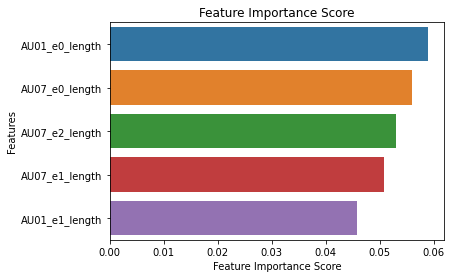

77

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

clf = RandomForestClassifier(criterion='entropy')
clf.fit(df, labels)
feature_imp = pd.Series(clf.feature_importances_,index=df.columns.tolist()).sort_values(ascending=False)

def plot_importance(clf):
    clf.fit(df, labels)
    feature_imp_ = pd.Series(clf.feature_importances_,index=df.columns.tolist()).sort_values(ascending=False)
    feature_imp_ = feature_imp_[0:5]


    sns.barplot(x=feature_imp_, y=feature_imp_.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")
    # plt.title("Hearing - Vs. None hearing")
#     plt.legend()
    plt.show()

plot_importance(clf)
len(feature_imp)

              precision    recall  f1-score   support

     signing       0.96      0.73      0.83        30
    speaking       0.91      0.99      0.95        84

    accuracy                           0.92       114
   macro avg       0.93      0.86      0.89       114
weighted avg       0.92      0.92      0.92       114

f1: 0.8893800539083558
prec: 0.9343048256091735
max_depth: 5


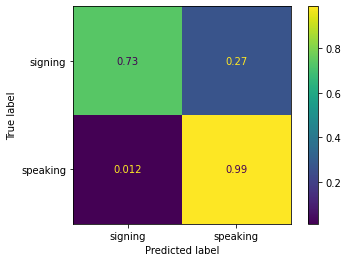

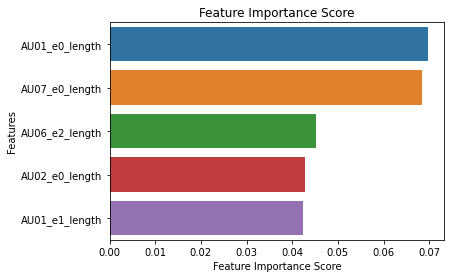

In [130]:
# xtrain = X_train[feature_imp[0:200].index.to_list()]
# xtest = X_test[feature_imp[0:200].index.to_list()]

xtrain = X_train
xtest = X_test

md = 5
clf = RandomForestClassifier(criterion='entropy', max_depth=md)
clf.fit(xtrain, y_train)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))
f1_ = f1_score(y_test, y_pred, average='macro')
prec = precision_score(y_test, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
print('max_depth:', md)
plot_importance(clf)


              precision    recall  f1-score   support

     signing       1.00      0.85      0.92       100
    speaking       0.95      1.00      0.97       280

    accuracy                           0.96       380
   macro avg       0.97      0.93      0.95       380
weighted avg       0.96      0.96      0.96       380

f1: 0.9464159811985898
prec: 0.9745762711864407
max_depth: 5


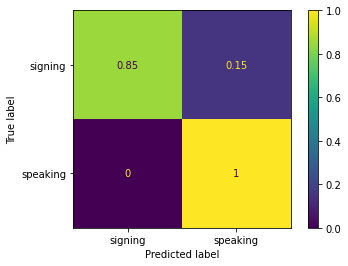

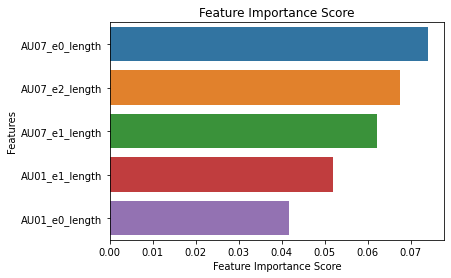

In [134]:
# overfit 
md = 5
clf = RandomForestClassifier(criterion='entropy', max_depth=md)
clf.fit(df, labels)

y_pred = clf.predict(df)
print(classification_report(labels, y_pred, labels=clf.classes_))
f1_ = f1_score(labels, y_pred, average='macro')
prec = precision_score(labels, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(labels, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
print('max_depth:', md)
plot_importance(clf)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:05<00:00,  2.63s/it]

features: 53 cv: 0.8763157894736843 


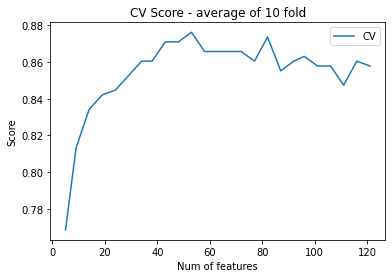

In [7]:
# cv score average per feature on the x -axis
from tqdm import tqdm
cv_aver = []
fe_range = np.linspace(5, 121, 25).astype(int)
for num_features in tqdm(fe_range):
    df_ = df[feature_imp[0:num_features].index.to_list()]
    clf = RandomForestClassifier(criterion='entropy', max_depth=11)
    cv_scores = cross_val_score(clf, df_, labels, cv=10)
    cv_aver.append(np.mean(cv_scores))

plt.plot(fe_range, cv_aver, label='CV')
plt.xlabel('Num of features')
plt.ylabel('Score')
plt.title('CV Score - average of 10 fold')
plt.legend()


max_idx = np.argmax(cv_aver)
features_max = fe_range[max_idx]
print(f'features: {features_max} cv: {cv_aver[max_idx]} ')

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
clf.fit(df, y)


fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')


In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
# clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
# clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf.estimators_[0], filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')


In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
# clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
# clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf.estimators_[0], filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')
